In [35]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
from numpy.linalg import norm
from random import random as rand
from random import seed
from numpy import sqrt
from copy import deepcopy as cp
from progressbar import ProgressBar
from celluloid import Camera
from IPython.display import HTML,Video
import ffmpeg
font = {'family' : 'serif',
        'size'   : 18}
rc('font', **font)

In [36]:
class source():

    def __init__(self,origin=None,vel=None,scale=1,dim=2):
        if(origin is None):
            self.origin = np.zeros((dim,1));
        else:
            self.origin = origin;
        if(vel is None):
            self.vel = np.zeros((dim,1));
        else:
            self.vel = vel;

        self.func,self.grad,self.lipschitz,self.polyak,self.minX,self.minVal,self.title = convexQuadratic(dim);
        self.minVal *= scale;
        self.scale = scale;

    def f(self,x):
        return self.scale*self.func(x-self.origin);

    def g(self,x):
        return self.scale*self.grad(x-self.origin);

    def minima(self):
        return np.array(self.minX+self.origin);

    def update(self,dt):
        self.origin += dt*self.vel;

    def move(self,dp):
        self.origin += dp;

    def accel(self,dv):
        self.vel += dv;

def convexQuadratic(dim=2):
    Q = 4*(np.random.random((dim,dim))-0.5);
    Q = Q.transpose().dot(Q) + np.eye(dim); #This makes it SDP, but has a tendency to flatten, so it is gently inflated.
    z = 20*(np.random.random((dim,1))-0.5);
    k = 0.5*z.transpose().dot(np.linalg.inv(Q).dot(z));
    # print(k)
    # The function 1/2 x^T Q x + z^T x + k
    # The minimum is at -(Q^{-1} z) w/ min value k-(1/2)z^T Q^{-1} z

    def f(x):
        return 0.5*x.transpose().dot(Q.dot(x))+z.transpose().dot(x)+k
    def g(x):
        return Q.dot(x)+z;
    minimizer = -np.linalg.inv(Q).dot(z);
    minVal = k-0.5*z.transpose().dot(np.linalg.inv(Q).dot(z));
    if(np.abs(minVal - f(minimizer)) > 1e-03):
        print("Minimizer seems wrong: ");
        print("Analytic minval: ",minVal);
        print("Computed Value at minimizer: ",f(minimizer));

    eVals,eVecs = np.linalg.eig(Q);
    lipshitz = np.max(eVals);
    polyak = np.min(eVals);
    title = "Convex Quadratic, Min at (";
    for i in range(dim-1):
        title += str(minimizer[i][0])+" , ";
    title += str(minimizer[-1][0])+")";
    # print("Q : ")
    # print(Q)
    # print("z : ")
    # print(z)
    # print("k : ")
    # print(k)
    return f,g,lipshitz,polyak,minimizer,minVal,title;

def usefulConstants(agents,s):
    N = len(agents);
    a = np.zeros((N,N),dtype=float); #seperation of i and j scaled by lipshitz, symmetric, zero diagonal
    d = np.zeros((N,N),dtype=float); #average slope from agent i to j, negative symmetric, zero diag
    v = {}; #unit vector from agent i to j
    for i in range(N):
        pi = agents[i].pos;
        for j in range(i+1,N):
            if(not agents[i].isNeighbour[j]):
                continue;
            pj = agents[j].pos;
            normij = np.linalg.norm(pi - pj);
            a[i,j] = a[j,i] = s.lipschitz/2*normij;
            d[i,j] = (s.f(pj) - s.f(pi))/normij;
            d[j,i] = -d[i,j];
            v[(i,j)] = (pj-pi)/normij;
            v[(j,i)] = -v[(i,j)];
    return d,v,a;

class agent:
    def __init__(self,i,pos,L,polyack):
        self.i = i;
        self.pos = np.array(pos);
        self.neighbours = [];
        self.isNeighbour = [];
        self.offsets = {};
        self.k = 1;
        self.mult = 10.0*L/polyack;

    def potential(self,positions,verbose=False):
        return self.mult*sum([np.linalg.norm(self.pos-positions[j]-self.offsets[(self.i,j)])**2 for j in self.neighbours]);

    def potentialGrad(self,positions,verbose=False):
        return 2*self.mult*sum([self.pos - positions[j] - self.offsets[(self.i,j)] for j in self.neighbours]);


In [37]:
def makeFormation(agents):

    # Octohedron:
    # Let the square in the middle be in the xy plane, then
    # the points are (0,0,0) , (s,0,0), (s,s,0), (0,s,0). The upper point then
    # must have coordinates (s/2,s/2,s/sqrt(2)) and lower (s/2,s/2,-s/sqrt(2));
    sq2 = np.sqrt(2);
    s = 3/sq2;
    offsets = {};

    N = len(agents);
    if(len(agents)!=6):
        raise NameError("Octahedrons only")

    # Neighbours
    agents[0].neighbours = [1,3,4,5];
    agents[1].neighbours = [0,2,4,5];
    agents[2].neighbours = [1,3,4,5];
    agents[3].neighbours = [0,2,4,5];
    agents[4].neighbours = [0,1,2,3];
    agents[5].neighbours = [0,1,2,3];

    for a in agents:
        a.isNeighbour = np.zeros((N),dtype=bool);
        for j in a.neighbours:
            a.isNeighbour[j] = True;

    # Offsets, all 12 edges
    offsets[(0,1)] = np.array([-s,0,0]).reshape((3,1));
    offsets[(0,3)] = np.array([0,-s,0]).reshape((3,1));
    offsets[(0,4)] = np.array([-s/2.0,-s/2.0,-s/sq2]).reshape((3,1));
    offsets[(0,5)] = np.array([-s/2.0,-s/2.0,s/sq2]).reshape((3,1));
    offsets[(1,2)] = np.array([0,-s,0]).reshape((3,1));
    offsets[(1,4)] = np.array([s/2,-s/2,-s/sq2]).reshape((3,1));
    offsets[(1,5)] = np.array([s/2,-s/2,s/sq2]).reshape((3,1));
    offsets[(2,3)] = np.array([s,0,0]).reshape((3,1));
    offsets[(2,4)] = np.array([s/2,s/2,-s/sq2]).reshape((3,1));
    offsets[(2,5)] = np.array([s/2,s/2,s/sq2]).reshape((3,1));
    offsets[(3,4)] = np.array([-s/2,s/2,-s/sq2]).reshape((3,1));
    offsets[(3,5)] = np.array([-s/2,s/2,s/sq2]).reshape((3,1));

    for entry in list(offsets.keys()):
        offsets[(entry[1],entry[0])] = -offsets[entry];
    # print(offsets)
    for i in range(N):
        agents[i].offsets = offsets;

    return

In [43]:
def simulateMoving(N = 10,rndSeed = -1,plot=True):

    boundary = 100;

    s = source(dim=3,origin=boundary*(2*np.random.random((3,1))-1));

    L = s.lipschitz;
    mu = s.polyak;
    alpha = 0.01*min(1.0/s.lipschitz,1.0/s.polyak);

    mean = s.origin + 100*(2*np.random.random((3,1))-1);
    sig = rand()*10;
    agents = [agent(i,np.random.normal(mean,sig),L,mu) for i in range(N)];
    makeFormation(agents);

    positions = [cp(a.pos) for a in agents];

    timeSteps = int(05.000*1000);
    gradError = np.zeros((timeSteps,N));
    gradErrorBound = np.zeros((timeSteps,N));
    trajectory = np.zeros((timeSteps,3,N));
    sourceTraj = np.zeros((timeSteps,3));
    minError = np.zeros((timeSteps));
    minErrorBound = np.zeros((timeSteps));
    potVal = np.zeros((timeSteps));

    pbar = ProgressBar();
    for t in pbar(range(timeSteps)):
        descents = [];
        positions = [a.pos for a in agents];
        d,v,a = usefulConstants(agents,s);
        for i in range(len(agents)):
            Neigh = len(agents[i].neighbours);
            A = np.zeros((Neigh,3));
            di = np.zeros((Neigh,1));
            meas_vector = np.zeros((3,1));
            for jth in range(Neigh):
                j = agents[i].neighbours[jth];
                A[jth,:] = v[(i,j)].flatten();
                meas_vector += d[i,j]*v[(i,j)];
                di[jth] = d[i,j];

            moorePen = np.linalg.pinv(A.transpose().dot(A));
            descent_i = moorePen.dot(meas_vector);

            trajectory[t,:,i] = positions[i].flatten();
            descents.append(-alpha*(descent_i+agents[i].potentialGrad(positions)));

        for i in range(len(agents)):
                agents[i].pos += descents[i];

        sourceTraj[t,:] = s.minima().flatten();

        s.move(trajec(t));

    return makeMovie(sourceTraj,trajectory);

    # return makeMovie;

def makeMovie(sourceTraj,agentsTraj,rndSeed=0):

    nFrames = agentsTraj.shape[0]
    nAgents = agentsTraj.shape[2]

    fig = plt.figure();
    ax = fig.gca(projection='3d');
    camera = Camera(fig);

    xs = [];
    ys = [];
    zs = [];
    for i in range(nAgents):
        xs.append(agentsTraj[:,0,i]);
        ys.append(agentsTraj[:,1,i]);
        zs.append(agentsTraj[:,2,i]);

    ax.plot(xs[0],ys[0],zs[0],alpha=0);
    ax.plot(sourceTraj[:,0],sourceTraj[:,1],sourceTraj[:,2],alpha=0)
    xlims = ax.get_xlim();
    ylims = ax.get_ylim();
    zlims = ax.get_zlim();
    counter = 0;
    print("Making data frames...")
    pbar = ProgressBar();    
    resolution = 100;                    #Selects every 1 in resolution frames, decrease for better resolution, increase for speed
    for n in pbar(range(0,nFrames,resolution)):
        for i in range(nAgents):
            ax.plot(xs[i][:n],ys[i][:n],zs[i][:n],color='black');
            ax.scatter(xs[i][n],ys[i][n],zs[i][n],color='black');
        ax.plot(sourceTraj[:n,0],sourceTraj[:n,1],sourceTraj[:n,2],color='red',linestyle='--')
        ax.scatter(sourceTraj[n,0],sourceTraj[n,1],sourceTraj[n,2],color='red',marker='*',s=100)
        ax.set_xticklabels([]);
        ax.set_yticklabels([]);
        ax.set_zticklabels([]);
        ax.grid
        ax.set_xlabel('Position Coordinate 1');
        ax.set_ylabel('Position Coordinate 2');
        ax.set_zlabel('Position Coordinate 3');
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_zlim(zlims)
        plt.tight_layout();
        counter += 1;
        camera.snap();

    nSec = 10; #number of seconds to complete the animation
    interval = 1000*nSec/counter; #interval between frames
    print("Creating animation...")
    return camera.animate();
    # animation.save('traj3d.mp4');


def trajec(t):
    # Give the difference between the current point (assumed to be t) and the next
    # on the path of some crazy function out of N steps.
    speed = 0.01;

    def crazyPath(time):
        return np.array([12*np.sin(.06*np.pi*time)+8*np.sin(.15*np.pi*time)+0.2*time,20*np.cos(.08*np.pi*time)+0.45*time,1.5*time]).reshape((3,1));

    return crazyPath(speed*(t+1))-crazyPath(speed*t);

Input random seed (-1 for random):  1234


100% |##############################################################################################|


Making data frames...


100% |##############################################################################################|


Creating animation...


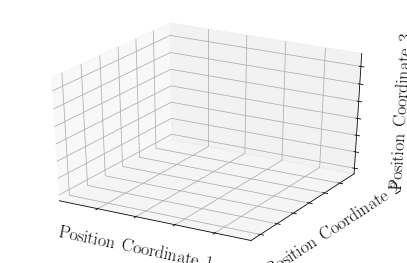

In [44]:
rndSeed = int(input("Input random seed (-1 for random): "));
if(rndSeed<0):
    rndSeed = np.random.randint(10000);
np.random.seed(rndSeed);
seed(rndSeed)
# print("Running with random seed %i " % rndSeed)

animation = simulateMoving(6,rndSeed,plot=True);
animation.save('traj3d.mp4')
Video("traj3d.mp4")